# Карты видимости
космических аппаратов с наземных пунктов с учетом различных условий

### Условие задачи


**Дано:**

- модуль [spiceypy](https://pypi.org/project/spiceypy/), реализующий python-интерфейс для библиотеки [SPICE](https://naif.jpl.nasa.gov/naif/aboutspice.html)
- датасет kernels.zip, содержащий файлы (ядра) с необходимыми данными для расчета временных интервалов
- набор функций `utils.py`, упрощающих работу со `spiceypy`


**Требуется:**


1. Выполнить расчеты окон видимости для следующих наземных пунктов, аппаратов и условий, представленных в таблице.
Окно видимости - это набор интервалов видимости внутри заданного временного отрезка.
**При расчетах необходимо корректно учесть, что для некоторых объектов информация в датасете покрывает заданный временной отрезок только частично.**

```
KIP = (BEAR, USSURIYSK)
dates = [2022-JUN-01, 2026-JUN-01]

№   target    observer  frame         min_elev  trg_spk               obs_spk
---------------------------------------------------------------------------------------------
1   LG_SITE1  KIP       KIP_TOPO      10        LunaGlob_site.bsp     earthstns_iau_earth.bsp
    intersect with
    SUN       LG_SITE1  LG_SITE1_TOPO  5        de432s.bsp            LunaGlob_site.bsp
2   -551      KIP       KIP_TOPO      10        spektr_rg.bsp         earthstns_iau_earth.bsp
3   -172      KIP       KIP_TOPO      10        exomars.bsp           earthstns_iau_earth.bsp
4   MARS      KIP       KIP_TOPO      10        mar097_2022_2032.bsp  earthstns_iau_earth.bsp
```
Обозначения:

`target` - цель наблюдения
`observer` - наблюдатель
`frame` - система отсчета
`min_elev` - минимальный угол места (широта в системе отсчета `_TOPO`)
`trg_spk` - SPK-файл с данными о траектории цели наблюдения
`obs_spk` - SPK-файл с данными о траектории наблюдателя
`dates` - заданный временной отрезок

`KIP` - наземный пункт (контрольно-измерительный пункт):
- Медвежьи озера (`BEAR`)
- Уссурийск (`USSURIYSK`)

`LG_SITE1` - одно из возможных мест посадки модуля Луна-Глоб
`SUN` - Солнце (звезда)
`-551` - космический аппарат Спектр-РГ
`-172` - космический аппарат Экзомарс
`MARS` - Марс (планета)

`intersect with` обозначает, что необходимо выполнить пересечение двух окон


2. Преобразовать рассчитанные окна видимости в `pandas DataFrame` со столбцами:

    - `start` (начало интервала видимости, формат `datetime`)
    - `end` (конец интервала видимости, формат `datetime`)
    - `duration` (продолжительность, формат `timedelta`)

    и **сохранить их в файлы** в форматах `pickle` и `csv`.


3. Повторить карты видимости:
   - [Медвежьи озера (BEAR.png)](BEAR.png)
   - [Уссурийск (USSURIYSK.png)](USSURIYSK.png)

    Карты видимости рассмотрены на семинаре 16.


4. Задокументировать все реализованные функции


**Материалы:**
- Библиотека [SPICE](https://naif.jpl.nasa.gov/naif/aboutspice.html)
- Семинары 15, 16


**Рекомендации:**
- использовать IDE **Pycharm** (полная версия для студентов и преподавателей)


**Правила оценивания:**

- оценка за корректно выполненные расчеты:
```
    KIP    =  BEAR USSURIYSK
    g(KIP) =  50   50
```

- штрафы $p(j)$, баллов:
    - небольшие погрешности в расчетах - 10
    - не сохранены файлы с результатами вычислений - 20
    - нет документации функций - 20
    - небольшие погрешности на графиках - 10
    - менее значимые недоработки - 10


- итоговая оценка за задание = $\sum_{KIP}g(KIP) - \sum_{j}{p(j)}$

In [1]:
!gdown --folder 19Vi96qvCGz10pMXL6DSszwU4rL6ZYt-w -O files 
!unzip files/kernels.zip -d files
!mkdir files/saved_vis_maps

Retrieving folder list
Processing file 11hXWt6jZXtUDJkRUW506X11mVZx70Yjy BEAR.png
Processing file 1agDMvKHXdcpTpXMjWe8JrmGuZU8pbSlP kernels.zip
Processing file 1TgR2o_JpjH_dvHkggIooOpmB7zYRX5Ob USSURIYSK.png
Processing file 1blc6quYuOkipsCncdzSe-ol4VYq1O76E utils.py
Retrieving folder list completed
Building directory structure
Building directory structure completed
Downloading...
From: https://drive.google.com/uc?id=11hXWt6jZXtUDJkRUW506X11mVZx70Yjy
To: /content/files/BEAR.png
100% 559k/559k [00:00<00:00, 123MB/s]
Downloading...
From: https://drive.google.com/uc?id=1agDMvKHXdcpTpXMjWe8JrmGuZU8pbSlP
To: /content/files/kernels.zip
100% 41.1M/41.1M [00:00<00:00, 130MB/s]
Access denied with the following error:

 	Cannot retrieve the public link of the file. You may need to change
	the permission to 'Anyone with the link', or have had many accesses. 

You may still be able to access the file from the browser:

	 https://drive.google.com/uc?id=1TgR2o_JpjH_dvHkggIooOpmB7zYRX5Ob 

Download en

In [2]:
!pip install spiceypy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
import spiceypy as spice
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from files import utils

In [4]:
utils.load_kernels_from_path('files/kernels')

['files/kernels/pck/pck00010.tpc',
 'files/kernels/pck/earth_latest_high_prec.bpc',
 'files/kernels/lsk/naif0012.tls.pc',
 'files/kernels/fk/LunaGlob_topo.tf',
 'files/kernels/fk/SEL2.tf',
 'files/kernels/fk/earthstns_iau_earth.tf',
 'files/kernels/fk/earth_assoc_itrf93.tf',
 'files/kernels/fk/earthfixediau.tf',
 'files/kernels/spk/LunaGlob_site.bsp',
 'files/kernels/spk/L2_de431.bsp',
 'files/kernels/spk/spektr_rg.bsp',
 'files/kernels/spk/exomars.bsp',
 'files/kernels/spk/mar097_2022_2032.bsp',
 'files/kernels/spk/de432s.bsp',
 'files/kernels/spk/earthstns_iau_earth.bsp']

In [5]:
def period_with_margin(period):
  """
  Немного обрезаем период, чтобы при расчетах не потребовались данные,
  выходящие за известный период
  params:
    period: np.array
      Список содержащий даты начала и конца в формате YYYY-MM-DD HR:MN:SC
  returns:
    spiceypy.utils.support_types.SPICEDOUBLE_CELL
      Ячейка, содержащая в себе обрезанный период
  """
  date_end = period[0, 1][:10]
  date_beg = period[0, 0][:10]
  date_beg = date_beg[:8] + str(int(date_beg[8:]) + 1)
  return utils.merge_intervals(
      np.array(
          [[spice.str2et(date_beg), spice.str2et(date_end)]]
      )
  )

In [6]:
from datetime import datetime, timedelta


def hour2float(t_col: pd.core.indexes.accessors.DatetimeProperties) -> float:
  """
  Переводим время в вещественное количество часов
  params:
    t_col: DateTimeProperties
      Содержит в себе время
  returns:
    float 
      Время вещественным числом
  """
  return t_col.hour + t_col.minute / 60 + t_col.second / 3600


def split_interval(start: datetime, end:datetime) -> pd.DataFrame:
  """
  Если период выходит за границы суток, 
  переводит остаток периода на следующие сутки,
  затем переводит в pd.DataFrame
  params:
    start: datetime
      Начало периода
    end: datetime
      Конец периода
  returns:
    pandas.DataFrame
      Преобразованный в датафрейм период с переносом
  """
  if start.date() == end.date():
    return pd.DataFrame(
        {
            'start': [start],
            'end': [end],
            'duration': [end - start]
        }
    )
  df = pd.DataFrame(
      {
          'start': [start, end.date()],
          'end': [end.date() - timedelta(seconds=1), end]
      }
  )
  df['duration'] = df.end - df.start
  return df

In [7]:
from matplotlib.dates import YearLocator, MonthLocator, DateFormatter
import matplotlib

colors = matplotlib.rcParams['axes.prop_cycle'].by_key()['color']
names = ('Луна-Глоб', '-551', '-172', 'MARS')
plot_names = ('Луна-Глоб (сол.)', 'Спектр-РГ', 'Экзомарс', 'Марс')

def draw_visibility_map(names, plot_names, df_wins, date_beg, date_end, KIP):
  """
  Отрисовка карты видимости
  params:
    names: tuple
      Названия объектов (из bsp файла)
    plot_names: tuple
      Названия объектов для отрисовки легенды
    df_wins: dict
      Словарь объектов pd.DataFrame, описывающих карты видимости объектов объектом KIP
    date_beg: str
      Дата начала исследуемого периода в виде строки в формате YYYY MON DD
    date_end: str
      Дата конца исследуемого периода в виде строки в формате YYYY MON DD
    KIP:
      название объекта, со стороны которого строится карта видимости
  """
  bars = {}
  colors = matplotlib.rcParams['axes.prop_cycle'].by_key()['color']

  plt.figure(figsize=(15, 5))

  for i, name in enumerate(names):
    df = df_wins[name]
    dfs = []
    for _, row in df.iterrows():
      dfs.append(split_interval(row.start, row.end))
    df = pd.concat(dfs)
    bottom = hour2float(df.start.dt)
    height = df.duration.dt.total_seconds() / 3600
    bar = plt.bar(df.start.dt.date, height=height, bottom=bottom, width=1, alpha=0.7)
    bars[i] = bar

  xax = plt.gca().xaxis
  xax.set_major_locator(YearLocator())
  xax.set_minor_locator(MonthLocator())
  xax.set_major_formatter(DateFormatter('%m\n%Y'))
  xax.set_minor_formatter(DateFormatter('%m'))
  plt.xlabel('Дата')
  plt.ylabel('Длительность, ч')
  plt.title(f'Карта видимости объектов с наземного пункта {KIP} от {date_beg} до {date_end}')
  plt.grid(which='both', ls='--', alpha=0.5)
  plt.tight_layout()
  plt.yticks(np.arange(25))
  plt.xlim(pd.to_datetime(date_beg), pd.to_datetime(date_end))
  plt.ylim(0, 24)
  plt.legend(bars.values(), plot_names)
  plt.show()

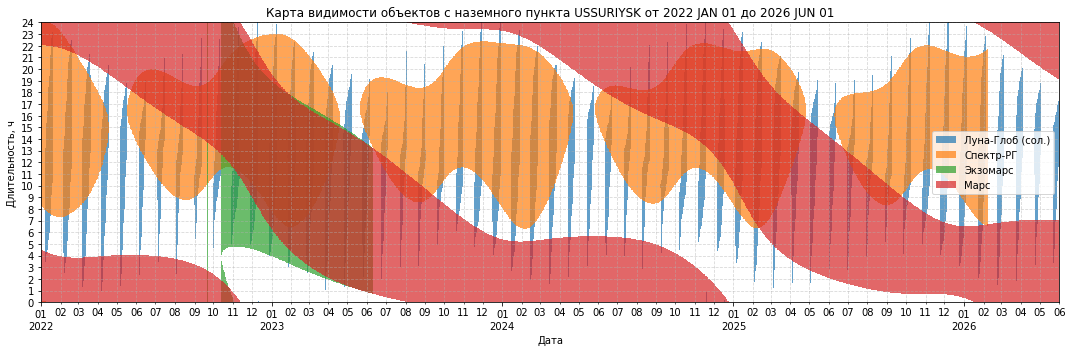

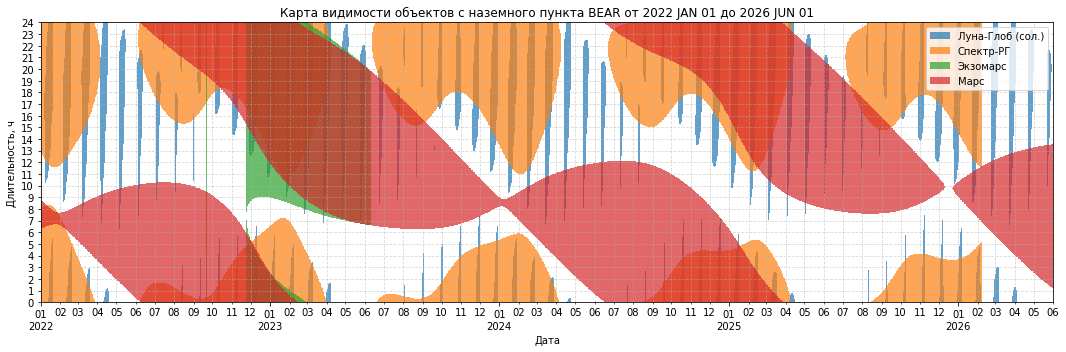

In [8]:
date_beg = '2022 JAN 01'
date_end = '2026 JUN 01'

spk = 'files/kernels/spk/'

et_beg = spice.str2et(date_beg)
et_end = spice.str2et(date_end)
et_stp = 86400.0

sun_wrt_lg = spice.gfposc(
    'SUN', 'LG_SITE1_TOPO', 'CN+S', 'LG_SITE1',
    'LATITUDINAL', 'LATITUDE', '>', np.deg2rad(5),
    0.0, 600, 10000, utils.merge_intervals(np.array([[et_beg, et_end]]))
)

et = np.arange(et_beg, et_end, et_stp)

KIP = ('USSURIYSK', 'BEAR')
pathes = {
    'LG_SITE1': spk + 'LunaGlob_site.bsp',
    'SUN': spk + 'de432s.bsp',
    '-551': spk + 'spektr_rg.bsp',
    '-172': spk + 'exomars.bsp',
    'MARS': spk + 'mar097_2022_2032.bsp',
    'BEAR': spk + 'earthstns_iau_earth.bsp',
    'USSURIYSK': spk + 'earthstns_iau_earth.bsp'
}

for i in range(2):
  KIP_id = 399601 + i
  params = (
      ('LG_SITE1', KIP[i], KIP[i]+'_TOPO', 'CN+S', 10),
      ('-551', KIP[i], KIP[i]+'_TOPO', 'CN+S', 10),
      ('-172', KIP[i], KIP[i]+'_TOPO', 'CN+S', 10),
      ('MARS', KIP[i], KIP[i]+'_TOPO', 'CN+S', 10)
  )

  base_wnd = utils.merge_intervals(np.array([[et_beg, et_end]]))
  base_wnd = utils.intersect_windows(
      base_wnd, 
      spice.spkcov(pathes[KIP[i]], KIP_id)
  )

  windows = {}
  for trg, obs, frm, abc, min_angle in params:
      search_wnd = period_with_margin(
          utils.window2calendar(
              utils.intersect_windows(
                base_wnd, 
                spice.spkcov(pathes[trg], spice.bods2c(trg)),
                spice.spkcov(pathes[obs], KIP_id)
              )
          )
      )
      cell = spice.utils.support_types.SPICEDOUBLE_CELL(10000)
      window = spice.gfposc(trg, frm, abc, obs,
                            'LATITUDINAL', 'LATITUDE', '>', np.deg2rad(min_angle),
                            0.0, 600, 10000, search_wnd, cell)
      windows[trg] = window

  windows['Луна-Глоб'] = utils.intersect_windows(windows['LG_SITE1'], sun_wrt_lg)
  df_wins = {key: utils.window2df(win) for key, win in windows.items()}
  for j in df_wins.keys():
    df_wins[j].to_pickle(f'files/saved_vis_maps/{j}_to_{KIP[i]}_vis_map.pkl')
    df_wins[j].to_csv(f'files/saved_vis_maps/{j}_to_{KIP[i]}_vis_map.csv')
  draw_visibility_map(names, plot_names, df_wins, date_beg, date_end, KIP[i])
